<a href="https://colab.research.google.com/github/eduardo-eal/TCC/blob/main/TCC3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#TCC Módulo C- Eduardo Amaral Lopes


#Recuperar arquivos tf-idf

In [1]:
import pickle
import pandas as pd
pathScriptFeatureStore= '/content/drive/MyDrive/PUC/16 - Projeto Integrado – Inteligência Artificial e Aprendizado de Máquina (2021)'

#recuperar classes

y_treino = pd.read_csv(pathScriptFeatureStore+'/y_treino.csv')
y_teste = pd.read_csv(pathScriptFeatureStore+'/y_teste.csv')

#recuperar TF-IDF

infile1 = open(pathScriptFeatureStore+'/X_treino_tfidf.sm','rb')
X_treino_tfidf = pickle.load(infile1)
infile1.close()

infile2 = open(pathScriptFeatureStore+'/X_teste_tfidf.sm','rb')
X_teste_tfidf = pickle.load(infile2)
infile2.close()

#recuperar TF-IDF em 3D para LSTM - (amostras,observações(1),features)

infile3 = open(pathScriptFeatureStore+'/X_treino_tfidf_3Darray.sm','rb')
X_treino_tfidf_3Darray = pickle.load(infile3)
infile3.close()

infile4 = open(pathScriptFeatureStore+'/X_teste_tfidf_3Darray.sm','rb')
X_teste_tfidf_3Darray = pickle.load(infile4)
infile4.close()

#Aplicação dos modelos

##Naive Bayes

O classificador multinomial Naïve Bayes é um dos modelos mais populares no aprendizado de máquina. Tomando como premissa a suposição de independência entre as variáveis do problema, o modelo de Naïve Bayes realiza uma classificação probabilística de observações, caracterizando-as em classes pré-definidas, no nosso caso notícias verdadeiras ou falsas. Esse classificador se ajusta melhor a features inteiras, como contadores de palavras por exemplo, mas como a documentação do sklearn informa que na prática funciona bem também com tf-idf, vamos usar método para todos os algoritmos. 
O único parâmetro que vamos ajustar será alpha=0.1 para incluir uma pequena suavização no modelo. (o padrão é alpha=1)

In [2]:
from sklearn.naive_bayes import MultinomialNB 

naive_bayes = MultinomialNB(alpha=0.1) 
naive_bayes.fit(X_treino_tfidf, y_treino)

y_predicao = naive_bayes.predict(X_teste_tfidf)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [3]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def imprimir_matriz_confusao(y_teste, y_predicao):
  cm = confusion_matrix(y_teste, y_predicao , labels=[0, 1])
  ax= plt.subplot()
  sns.heatmap(cm, annot=True, ax= ax, fmt='d' )
  ax.set_ylabel('y_teste')
  ax.set_xlabel('y_predicao')

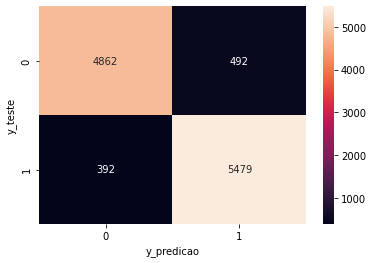

In [4]:
imprimir_matriz_confusao(y_teste, y_predicao)

In [5]:
metricas = pd.DataFrame(columns=['modelo','accuracy', 'precision', 'recall', 'f1'])


In [6]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score


def get_metrics(y_teste, y_predicao):  
    precision = round(precision_score(y_teste, y_predicao, pos_label=1, average='macro'),4)             
    recall = round(recall_score(y_teste, y_predicao, pos_label=1, average='macro'),4)
    f1 = round(f1_score(y_teste, y_predicao, pos_label=1, average='macro'),4)
    accuracy = round(accuracy_score(y_teste, y_predicao),4)
    return accuracy, precision, recall, f1

In [7]:
accuracy, precision, recall, f1 = get_metrics(y_teste, y_predicao)
metricas.loc[len(metricas)] = ['MultinomialNB', accuracy, precision, recall, f1]

##XGBoost
XGBoost é uma biblioteca otimizada e distribuída de gradient boosting projetada para ser altamente eficiente, flexível e portável. Ele implementa algoritmos de machine learning baseados em árvores de decisão no framework de Gradiente Boosting.
Utilizamos os seguintes parâmetros baseados em outros casos da utilização de XGBoost para classificação de textos:

max_depth=6 
profundidade máxima da árvore

n_estimators=100
Número de estimadores/árvores construidas no treinamento

colsample_bytree=0.8
Taxa do subconjunto a ser utilizado ao construir cada árvore

subsample=0.8
Taxa do subconjunto a ser utilizado na instância de treinamento

nthread=10
Número de thread utilizadas ao paralelizar

learning_rate=0.3
Taxa de aprendizado

In [8]:
import xgboost as xgb


modelo_xgboost = xgb.XGBClassifier(max_depth=6, n_estimators=100, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.3)
modelo_xgboost.fit(X_treino_tfidf, y_treino)


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


XGBClassifier(colsample_bytree=0.8, learning_rate=0.3, max_depth=6, nthread=10,
              subsample=0.8)

In [9]:
y_predicao = modelo_xgboost.predict(X_teste_tfidf)
y_predicao

array([0, 1, 0, ..., 0, 0, 0])

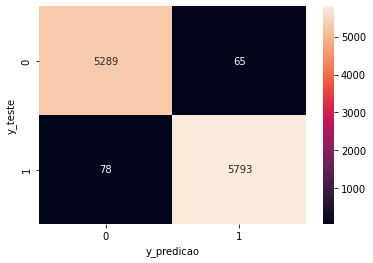

In [10]:
imprimir_matriz_confusao(y_teste, y_predicao)

In [11]:
accuracy, precision, recall, f1 = get_metrics(y_teste, y_predicao)
metricas.loc[len(metricas)] = ['XGBoost', accuracy, precision, recall, f1]

##LSTM

LSTM ou Long Short Term Memory é um tipo de rede neural recorrente(RNN) que é usada em diversos cenários de Processamento de Linguagem Natural.
Para o construir o modelo, como estamos utilizando o mesmo encoding tf-idf para os 3 modelos (apenas adaptando o formato 3D para a LSTM), não utilizaremos a camada de Encoding. Serão usadas apenas duas camadas: Uma LSTM e uma camada Densa com ativação sigmoid. Assim como nos outros modelos, nos baseamos na parametrização de modelos usados para classificação de textos e visamos manter o modelo simples.

Usaremos os seguintes parâmetros:

Camada LSTM:

input_shape=(1,FEATURES) 
Formato da entrada com número de observações no tempo, nessa caso apenas uma e número de features que foi limitado em 1000 para todos os modelos

units=4 
Dimensionalidade da saída

dropout=0.1
Taxa de descarte

Camada Densa:

units=1
Dimensionalidade da saída

activation='sigmoid'
Função de ativação

Parâmetros para compilação do modelo:

optimizer='adam'
Otimizado a ser utilizado 

loss='binary_crossentropy'
Medida de perda utilizada no processo de aprendizagem

metrics=['accuracy']
métrica a ser obtida


In [12]:
import tensorflow as tf
from tensorflow import keras

In [13]:
FEATURES = 1000

In [14]:
modelo_lstm = keras.Sequential()
modelo_lstm.add(keras.layers.LSTM(input_shape=(1,FEATURES), units=4, dropout=0.1))
modelo_lstm.add(keras.layers.Dense(1,activation='sigmoid'))
modelo_lstm.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
modelo_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 4)                 16080     
                                                                 
 dense (Dense)               (None, 1)                 5         
                                                                 
Total params: 16,085
Trainable params: 16,085
Non-trainable params: 0
_________________________________________________________________


In [15]:
historico = modelo_lstm.fit(X_treino_tfidf_3Darray, y_treino, epochs=20,batch_size=64, verbose=1, validation_data=(X_teste_tfidf_3Darray,y_teste))


Epoch 1/20
527/527 [==============================] - 10s 7ms/step - loss: 0.4276 - accuracy: 0.8914 - val_loss: 0.2256 - val_accuracy: 0.9454
Epoch 2/20
527/527 [==============================] - 2s 5ms/step - loss: 0.1735 - accuracy: 0.9535 - val_loss: 0.1353 - val_accuracy: 0.9621
Epoch 3/20
527/527 [==============================] - 3s 5ms/step - loss: 0.1181 - accuracy: 0.9644 - val_loss: 0.1035 - val_accuracy: 0.9681
Epoch 4/20
527/527 [==============================] - 3s 6ms/step - loss: 0.0958 - accuracy: 0.9693 - val_loss: 0.0874 - val_accuracy: 0.9708
Epoch 5/20
527/527 [==============================] - 3s 5ms/step - loss: 0.0833 - accuracy: 0.9721 - val_loss: 0.0786 - val_accuracy: 0.9723
Epoch 6/20
527/527 [==============================] - 3s 5ms/step - loss: 0.0768 - accuracy: 0.9747 - val_loss: 0.0728 - val_accuracy: 0.9736
Epoch 7/20
527/527 [==============================] - 2s 5ms/step - loss: 0.0712 - accuracy: 0.9754 - val_loss: 0.0691 - val_accuracy: 0.9746
Epoch

In [16]:
y_predicao = modelo_lstm.predict(X_teste_tfidf_3Darray)

In [17]:
y_predicao

array([[6.2264954e-03],
       [9.9917430e-01],
       [6.9653161e-04],
       ...,
       [1.4274512e-04],
       [3.6993150e-03],
       [3.7288433e-04]], dtype=float32)

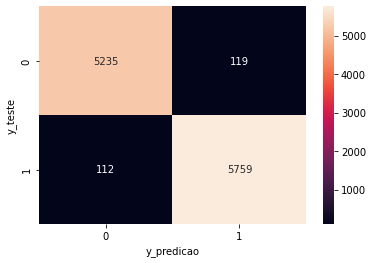

In [18]:
import numpy as np

imprimir_matriz_confusao(y_teste, np.round(y_predicao))

In [19]:
accuracy, precision, recall, f1 = get_metrics(y_teste, np.round(y_predicao))
metricas.loc[len(metricas)] = ['LSTM', accuracy, precision, recall, f1]

In [20]:
metricas

,modelo,accuracy,precision,recall,f1
0,MultinomialNB,0.9212,0.9215,0.9207,0.9210
1,XGBoost,0.9873,0.9872,0.9873,0.9872
2,LSTM,0.9794,0.9794,0.9793,0.9794


Observando o quadro acima, verificamos que as diferentes métricas de um mesmo modelo estão muito próximas, por isso a escolha da métrica não terá impacto em nossa análise.
Vamos usar a acuracia, que indica a performance geral do modelo, dentre todas as classificações, quantas o modelo acertou.

*Multinomial Naive Bayes
com uma acurácia de 0,92 foi o modelo que apresentou pior resultado entre os analisados. Utilizando todas as features disponíveis conseguimos um resultado um pouco melhor, de 0,96, mas visando uma melhor combinação entre acurácia e tempo de processamento, utilizamos o limite de 1000 features para todos os modelos.

*LSTM
O modelo utilizando redes LSTM obteve a segunda melhor acurácia, com 0,97.
Considerando que não fizemos uma busca automatizada por hiperparâmetros, podemos considerar que está bem próximo de um empate com o modelo de melhor acurácia.

*XGBoost
Foi o modelo com melhor acurácia, atingindo 0,98. 
Por isso será o modelo utilizado em nosso pipeline.



In [21]:
#Salvando os resultados
pathScript= '/content/drive/MyDrive/PUC/16 - Projeto Integrado – Inteligência Artificial e Aprendizado de Máquina (2021)'

#Gravar classes

metricas.to_csv(pathScript+'/metricas.csv', index=False)